<a href="https://colab.research.google.com/github/StratosFair/DNN_Classifiers_Fast_Rates/blob/main/concentric_circles_hard_margin.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

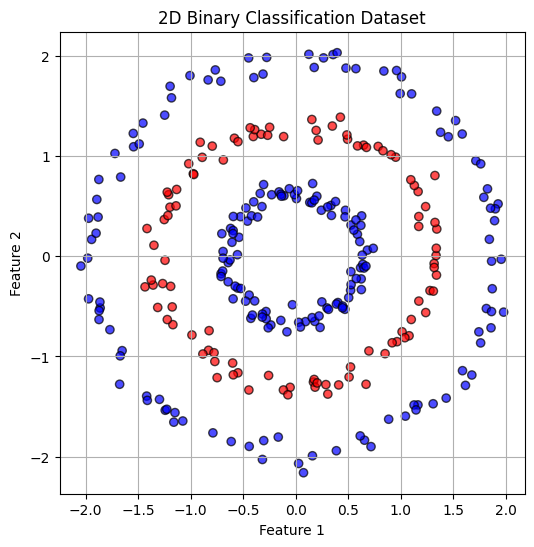

In [2]:
# Function to generate a 2D binary classification dataset
def generate_2d_dataset(n_samples, n_circles=3, noise=0.1, random_state=42):
    np.random.seed(random_state)
    samples_per_circle = n_samples // n_circles
    X, y = [], []

    for i in range(n_circles):
        # Radius of the current circle
        radius = (i + 1) * 1.0
        # Generate angles for points
        angles = np.linspace(0, 2 * np.pi, samples_per_circle, endpoint=False)
        # Add noise to radius and angle
        r = radius + noise * np.random.randn(samples_per_circle)
        theta = angles + noise * np.random.randn(samples_per_circle)
        # Convert polar coordinates (r, theta) to Cartesian (x, y)
        x_circle = np.stack([r * np.cos(theta), r * np.sin(theta)], axis=1)
        X.append(x_circle)
        # Alternate class labels (0, 1)
        y.extend([i % 2] * samples_per_circle)

    # Combine all circles into a single dataset
    X = np.vstack(X)
    y = np.array(y)

    # Shuffle the dataset
    indices = np.random.permutation(len(y))
    X, y = X[indices], y[indices]

    # Standardize features for better optimization
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    return X, y

# Function to visualize the dataset
def plot_dataset(X, y, title="2D Binary Classification Dataset"):
    plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', edgecolor='k', alpha=0.7)
    plt.title(title)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.grid(True)
    plt.show()

# Generate and visualize the dataset
X, y = generate_2d_dataset(300)  # Example with 300 samples
plot_dataset(X, y)

In [3]:
# Define the deep fully connected ReLU network
class DeepReLUModel(nn.Module):
    def __init__(self, input_dim):
        super(DeepReLUModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)  # Single output for binary classification
        )

    def forward(self, x):
        return self.model(x)

In [4]:
# Train the model and record the loss
def train_model(X_train, y_train, model, criterion, optimizer, epochs=100):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_train).squeeze()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [5]:
def run_experiment(sample_sizes, epochs=5000):
    """
    Train models for varying dataset sizes and return validation losses.

    Args:
        sample_sizes (list): List of dataset sizes to evaluate.
        epochs (int): Number of epochs for training.

    Returns:
        sample_sizes (list): The dataset sizes used.
        validation_losses (list): The validation losses for each dataset size.
    """
    validation_losses = []  # Track validation loss for each dataset size
    input_dim = 2  # 2D points

    for idx, n_samples in enumerate(sample_sizes):
        print(f"Training with dataset size: {n_samples} (run {idx + 1}/{len(sample_sizes)})")

        # Generate dataset
        X, y = generate_2d_dataset(n_samples)
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

        # Convert to PyTorch tensors
        X_train = torch.tensor(X_train, dtype=torch.float32)
        y_train = torch.tensor(y_train, dtype=torch.float32)
        X_val = torch.tensor(X_val, dtype=torch.float32)
        y_val = torch.tensor(y_val, dtype=torch.float32)

        # Initialize model, loss, and optimizer
        model = DeepReLUModel(input_dim)
        criterion = nn.MSELoss()  # Square loss
        optimizer = optim.Adam(model.parameters(), lr=0.001)

        # Train model
        _ = train_model(X_train, y_train, model, criterion, optimizer, epochs=epochs)

        # Compute validation loss
        model.eval()  # Set model to evaluation mode
        with torch.no_grad():  # Disable gradient computation for validation
            val_outputs = model(X_val).squeeze()
            val_loss = criterion(val_outputs, y_val).item()  # Compute validation loss
        validation_losses.append(val_loss)  # Record validation loss

    return sample_sizes, validation_losses

Training with dataset size: 50 (run 1/20)
Training with dataset size: 147 (run 2/20)
Training with dataset size: 245 (run 3/20)
Training with dataset size: 342 (run 4/20)
Training with dataset size: 440 (run 5/20)
Training with dataset size: 537 (run 6/20)
Training with dataset size: 635 (run 7/20)
Training with dataset size: 732 (run 8/20)
Training with dataset size: 830 (run 9/20)
Training with dataset size: 927 (run 10/20)
Training with dataset size: 1025 (run 11/20)
Training with dataset size: 1122 (run 12/20)
Training with dataset size: 1220 (run 13/20)
Training with dataset size: 1317 (run 14/20)
Training with dataset size: 1415 (run 15/20)
Training with dataset size: 1512 (run 16/20)
Training with dataset size: 1610 (run 17/20)
Training with dataset size: 1707 (run 18/20)
Training with dataset size: 1805 (run 19/20)
Training with dataset size: 1902 (run 20/20)
Results: {'sample_sizes': [50, 147, 245, 342, 440, 537, 635, 732, 830, 927, 1025, 1122, 1220, 1317, 1415, 1512, 1610, 17

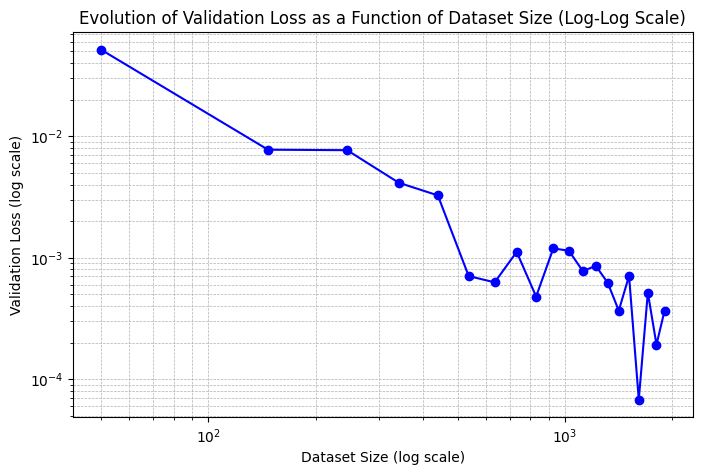

In [6]:
# Define dataset sizes and run the experiment
length = 20
upper, lower = 2000, 50
sample_sizes = [lower + int(x * (upper - lower) / length) for x in range(length)]

# Run the experiment
sample_sizes, validation_losses = run_experiment(sample_sizes, epochs=5000)

# Save the results for further processing
results = {"sample_sizes": sample_sizes, "validation_losses": validation_losses}
print("Results:", results)

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, validation_losses, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Logarithmic scale for dataset size
plt.yscale('log')  # Logarithmic scale for loss (optional, can be linear if preferred)
plt.xlabel("Dataset Size (log scale)")
plt.ylabel("Validation Loss (log scale)")
plt.title("Evolution of Validation Loss as a Function of Dataset Size (Log-Log Scale)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)
plt.show()

In [7]:
def fit_and_plot_loglog(sample_sizes, validation_losses):
    """
    Fit a line to the log-log plot and plot the original data with the fitted line.

    Args:
        sample_sizes (list): Dataset sizes.
        validation_losses (list): Validation losses corresponding to dataset sizes.
    """
    # Step 1: Take the log of the dataset sizes and validation losses
    log_sample_sizes = np.log(sample_sizes)
    log_validation_losses = np.log(validation_losses)

    # Step 2: Fit a linear model to the log-log data
    # np.polyfit fits a polynomial of degree 1 (a line) to the data
    slope, intercept = np.polyfit(log_sample_sizes, log_validation_losses, 1)

    # Step 3: Generate the fitted line in log-log space
    fitted_log_losses = slope * log_sample_sizes + intercept

    # Step 4: Plot the original data and the fitted line
    plt.figure(figsize=(8, 5))
    plt.plot(sample_sizes, validation_losses, 'o', label="Validation Loss (data)", color='blue')
    plt.plot(sample_sizes, np.exp(fitted_log_losses), '-', label=f"Fitted Line (slope = {slope:.2f})", color='red')
    plt.xscale('log')  # Logarithmic scale for the x-axis
    plt.yscale('log')  # Logarithmic scale for the y-axis
    plt.xlabel("Dataset Size (log scale)")
    plt.ylabel("Validation Loss (log scale)")
    plt.title("Validation Loss vs Dataset Size (Log-Log Scale)")
    plt.legend()
    plt.grid(True, which="both", linestyle="--", linewidth=0.5)
    plt.show()

    # Step 5: Print the slope for interpretation
    print(f"The slope of the fitted line is {slope:.2f}.")
    print(f"This suggests the error decays at a polynomial rate of approximately O(n^{slope:.2f}).")

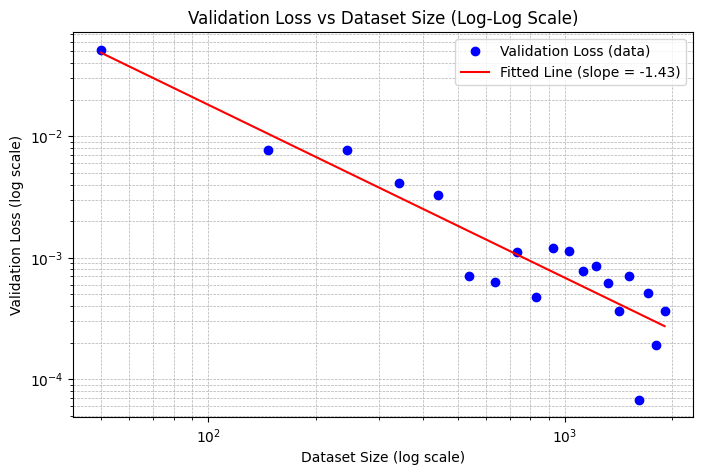

The slope of the fitted line is -1.43.
This suggests the error decays at a polynomial rate of approximately O(n^-1.43).


In [8]:
fit_and_plot_loglog(sample_sizes, validation_losses)